In [12]:
%%writefile config.py

import torch

class Config:
    MODEL_ID = "facebook/DiT-XL-2-256"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    DTYPE = torch.float16 
    IMAGE_SIZE = 256
    NUM_INFERENCE_STEPS = 50
    GUIDANCE_SCALE = 4.0
    TIMESTEP_INPUT_DIM = 1  
    TIMESTEP_EMBEDDING_DIM = 1152
    PREDICTOR_HIDDEN_DIM = 64
    PREDICTOR_OUTPUT_DIM = 2 
    OUTPUT_DIR = "./output_images"


Overwriting config.py


In [13]:
%%writefile predictor.py

import torch
import torch.nn as nn

class DynamicActivationPredictor(nn.Module):
    def __init__(self, input_dim=1152, hidden_dim=192, output_dim=2):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        self.initialize_weights()

    def initialize_weights(self):
        torch.nn.init.constant_(self.net[-1].weight, 0)
        torch.nn.init.constant_(self.net[-1].bias, 0)
        with torch.no_grad():
            self.net[-1].bias[0] = 1.0 

    def forward(self, t_emb):
        return self.net(t_emb)

Overwriting predictor.py


In [14]:
%%writefile pipeline_utils.py

import torch
import os
from diffusers import DiTPipeline, DPMSolverMultistepScheduler
from config import Config

class DiTInfrastructure:
    def __init__(self):
        self.config = Config()
        self.pipe = None
        
    def load_pipeline(self):
        print(f"Loading DiT model: {self.config.MODEL_ID}...")
        
        self.pipe = DiTPipeline.from_pretrained(
            self.config.MODEL_ID, 
            torch_dtype=self.config.DTYPE
        )

        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(
            self.pipe.scheduler.config
        )
        
        self.pipe = self.pipe.to(self.config.DEVICE)
        print("Model loaded successfully.")

    def generate_baseline_images(self, class_labels, seed=42):
        if self.pipe is None:
            self.load_pipeline()
            
        generator = torch.manual_seed(seed)
        
        print(f"Generating baseline images for classes: {class_labels}")

        output = self.pipe(
            class_labels=class_labels,
            num_inference_steps=self.config.NUM_INFERENCE_STEPS,
            guidance_scale=self.config.GUIDANCE_SCALE,
            generator=generator
        )
        
        images = output.images
        os.makedirs(self.config.OUTPUT_DIR, exist_ok=True)
        paths = []
        for i, (img, label) in enumerate(zip(images, class_labels)):
            path = f"{self.config.OUTPUT_DIR}/baseline_class_{label}_{i}.png"
            img.save(path)
            paths.append(path)
            
        print(f"Saved {len(images)} images to {self.config.OUTPUT_DIR}")
        return images, paths

Overwriting pipeline_utils.py


In [15]:
!pwd
!ls

/content
config.py  pipeline_utils.py  predictor.py  __pycache__  sample_data


Loading DiT model: facebook/DiT-XL-2-256...


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Expected types for id2label: (typing.Dict[int, str], <class 'NoneType'>), got typing.Dict[str, str].


Model loaded successfully.
Generating baseline images for classes: [207, 992]


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 2 images to ./output_images

--- Baseline Results (FP16 Gold Standard) ---


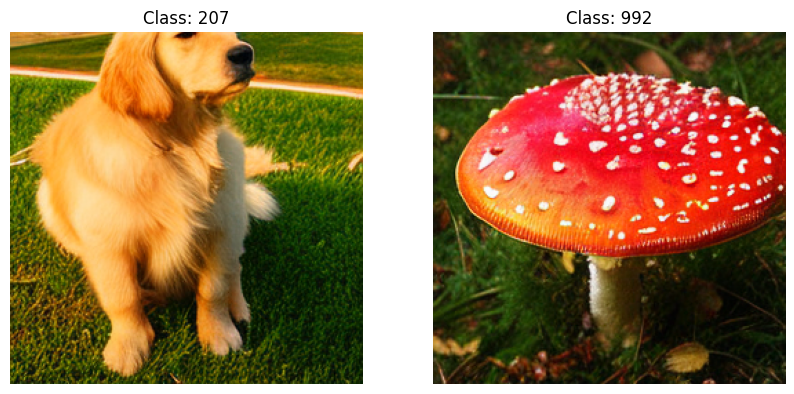


--- Testing Secondary Network (Predictor) ---
Input Embedding Shape: torch.Size([1, 1152])
Output Tensor Shape:   torch.Size([1, 2])
------------------------------
Predicted Scale (S):      1.000000 (Target ~1.0)
Predicted Zero-Point (Z): 0.000000 (Target ~0.0)
------------------------------
SUCCESS: Predictor initialized correctly near Identity.


In [17]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

from config import Config
from predictor import DynamicActivationPredictor
from pipeline_utils import DiTInfrastructure


infra = DiTInfrastructure()

# ImageNet Classes: 207 (Golden Retriever), 992 (Agaric/Mushroom)
class_ids = [207, 992] 
images, paths = infra.generate_baseline_images(class_labels=class_ids)

# Display Baseline Results
print("\n--- Baseline Results (FP16 Gold Standard) ---")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, path in enumerate(paths):
    img = Image.open(path)
    axs[i].imshow(img)
    axs[i].set_title(f"Class: {class_ids[i]}")
    axs[i].axis('off')
plt.show()

print("\n--- Testing Secondary Network (Predictor) ---")

predictor = DynamicActivationPredictor(
    input_dim=Config.TIMESTEP_EMBEDDING_DIM, # 1152
    hidden_dim=Config.PREDICTOR_HIDDEN_DIM,  # 192
    output_dim=Config.PREDICTOR_OUTPUT_DIM   # 2
)


dummy_embedding = torch.randn(1, Config.TIMESTEP_EMBEDDING_DIM)

with torch.no_grad():
    output = predictor(dummy_embedding)
    
scale = output[0][0].item()
zero_point = output[0][1].item()

print(f"Input Embedding Shape: {dummy_embedding.shape}")
print(f"Output Tensor Shape:   {output.shape}")
print("-" * 30)
print(f"Predicted Scale (S):      {scale:.6f} (Target ~1.0)")
print(f"Predicted Zero-Point (Z): {zero_point:.6f} (Target ~0.0)")
print("-" * 30)

if 0.9 <= scale <= 1.1 and -0.1 <= zero_point <= 0.1:
    print("SUCCESS: Predictor initialized correctly near Identity.")
else:
    print("WARNING: Initialization weights might need adjustment.")